In [35]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import pickle
import seaborn as sns
import random
from scipy.stats import linregress

In [36]:
with open("../data/interim/01_data_preprocessed.pkl", "rb") as file:
    df1 = pickle.load(file)

In [37]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,WOOLLY HOTTIE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Original DF - [Transaction Status]

In [38]:
# dealing with cancellations --> mark order as cancelled
# if invoice number = cancelled, mark as that
# Create a new column 'Transaction_Status' based on 'InvoiceNo' values
df1['Transaction_Status'] = np.where(df1['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

df1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed
1,536365,71053,METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,WOOLLY HOTTIE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed


In [56]:
df1.shape

(399656, 9)

In [39]:
# upload to the interim 
df1.to_pickle("../data/interim/02_data_preprocessed.pkl")

New DF


customerID
time since last purchase
how many purchases have they made (num of total purchases) per customer
average price of their purchases
total amount spent
average basket size (ie.number of objects per purchase)
Number of Cancellations
Spending_Trend

In [40]:
with open("../data/interim/02_data_preprocessed.pkl", "rb") as file:
    df2 = pickle.load(file)

In [41]:
# Convert InvoiceDate to datetime type
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df2['InvoiceDay'] = df2['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df2.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
latest_purchase = df2['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
latest_purchase = pd.to_datetime(latest_purchase)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (latest_purchase - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [42]:
total_transactions = df2.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Purchases'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases
0,12346.0,325,2
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1


In [43]:
# total amount spent
df2['Total_Spent'] = df2['UnitPrice'] * df2['Quantity']
total_spent = df2.groupby('CustomerID')['Total_Spent'].sum().reset_index()


# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spent, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent
0,12346.0,325,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,18,1,1457.55
4,12350.0,310,1,294.40


In [44]:
average_transaction_value = total_spent.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Value/Purchase'] = average_transaction_value['Total_Spent'] / average_transaction_value['Total_Purchases']

# Merge the average transaction value with your customer data
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Value/Purchase']], on='CustomerID')


# Round the 'Average_Value/Purchase' column to 2 decimal points
customer_data['Average_Value/Purchase'] = customer_data['Average_Value/Purchase'].round(2)

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase
0,12346.0,325,2,0.00,0.00
1,12347.0,2,7,4310.00,615.71
2,12348.0,75,4,1437.24,359.31
3,12349.0,18,1,1457.55,1457.55
4,12350.0,310,1,294.40,294.40


In [45]:
# Calculate the total number of products purchased by each customer
total_products_purchased = df2.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Bought'}, inplace=True)

customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase,Total_Products_Bought
0,12346.0,325,2,0.00,0.00,0
1,12347.0,2,7,4310.00,615.71,2458
2,12348.0,75,4,1437.24,359.31,2332
3,12349.0,18,1,1457.55,1457.55,630
4,12350.0,310,1,294.40,294.40,196


In [46]:
# Calculate the total number of transactions made by each customer
total_transactions = df2.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df2[df2['Transaction_Status'] == 'Cancelled']
cancellation_freq = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_freq.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_freq, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)


customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase,Total_Products_Bought,Cancellation_Frequency
0,12346.0,325,2,0.00,0.00,0,1.0
1,12347.0,2,7,4310.00,615.71,2458,0.0
2,12348.0,75,4,1437.24,359.31,2332,0.0
3,12349.0,18,1,1457.55,1457.55,630,0.0
4,12350.0,310,1,294.40,294.40,196,0.0


In [47]:
# Monthly Spending + Spending Trend

'''
This reflects the trend in a customer's spending over time
 A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction.
 Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies.
 A near-zero value signifies stable spending habits
'''

# Extract month and year from InvoiceDate
df2['Year'] = df2['InvoiceDate'].dt.year
df2['Month'] = df2['InvoiceDate'].dt.month


# Calculate monthly spending for each customer
monthly_spending = df2.groupby(['CustomerID', 'Year', 'Month'])['Total_Spent'].sum().reset_index()

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spent'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spent': 'Trend'}, inplace=True)

# Calculate the average monthly spending for each customer
average_monthly_spending = monthly_spending.groupby('CustomerID')['Total_Spent'].mean().reset_index()
average_monthly_spending.rename(columns={'Total_Spent': 'Average_Monthly_Spending'}, inplace=True)

# Merge the "Spending_Trend" and "Average_Monthly_Spending" data into the customer_data DataFrame
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')
customer_data = pd.merge(customer_data, average_monthly_spending, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase,Total_Products_Bought,Cancellation_Frequency,Trend,Average_Monthly_Spending
0,12346.0,325,2,0.00,0.00,0,1.0,0.000000,0.000000
1,12347.0,2,7,4310.00,615.71,2458,0.0,4.486071,615.714286
2,12348.0,75,4,1437.24,359.31,2332,0.0,-100.884000,359.310000
3,12349.0,18,1,1457.55,1457.55,630,0.0,0.000000,1457.550000
4,12350.0,310,1,294.40,294.40,196,0.0,0.000000,294.400000


In [49]:
# upload to the interim 
customer_data.to_pickle("../data/interim/01_customer_data_preprocessed.pkl")

In [50]:
with open("../data/interim/01_customer_data_preprocessed.pkl", "rb") as file:
    df3 = pickle.load(file)

Outlier on Customer_Data

In [51]:
# Define a threshold for the Z-score to identify outliers (e.g., |Z-score| > 3)
z_score_threshold = 3

# Calculate Z-scores for the entire DataFrame
z_scores = np.abs((df3 - df3.mean()) / df3.std())

# Create a new column "Is_Outlier" for each row indicating whether any of the Z-scores exceed the threshold
df3['Is_Outlier'] = z_scores.apply(lambda row: any(row > z_score_threshold), axis=1)

# Display the DataFrame with the "Is_Outlier" column
df3.head()

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase,Total_Products_Bought,Cancellation_Frequency,Trend,Average_Monthly_Spending,Is_Outlier
0,12346.0,325,2,0.00,0.00,0,1.0,0.000000,0.000000,False
1,12347.0,2,7,4310.00,615.71,2458,0.0,4.486071,615.714286,False
2,12348.0,75,4,1437.24,359.31,2332,0.0,-100.884000,359.310000,False
3,12349.0,18,1,1457.55,1457.55,630,0.0,0.000000,1457.550000,False
4,12350.0,310,1,294.40,294.40,196,0.0,0.000000,294.400000,False


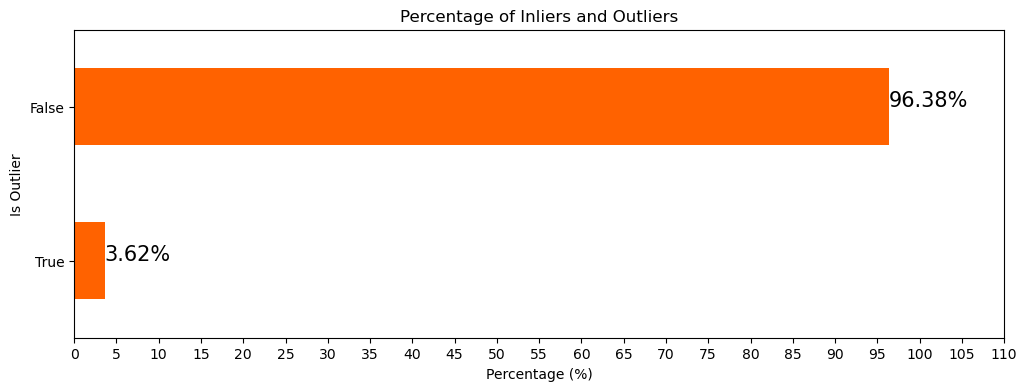

In [52]:
# Calculate the percentage of inliers and outliers
outlier_percentage = df3['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [57]:
# Filter rows where 'Is_Outlier' is False
df3 = df3[df3['Is_Outlier'] == False]
df3.reset_index(drop=True, inplace=True)
df3.shape

(4204, 10)

In [58]:
df3.head(5)

,CustomerID,Days_Since_Last_Purchase,Total_Purchases,Total_Spent,Average_Value/Purchase,Total_Products_Bought,Cancellation_Frequency,Trend,Average_Monthly_Spending,Is_Outlier
0,12346.0,325,2,0.00,0.00,0,1.0,0.000000,0.000000,False
1,12347.0,2,7,4310.00,615.71,2458,0.0,4.486071,615.714286,False
2,12348.0,75,4,1437.24,359.31,2332,0.0,-100.884000,359.310000,False
3,12349.0,18,1,1457.55,1457.55,630,0.0,0.000000,1457.550000,False
4,12350.0,310,1,294.40,294.40,196,0.0,0.000000,294.400000,False


In [61]:
# upload to the interim 
df3.to_pickle("../data/interim/02_customer_data_preprocessed.pkl")